In [13]:
import os
import cv2
import torch
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from dataset import create_loader
from preprocessing import visualize_augmentations
from evaluate import predict, display_image_grid, conf_matrix
from classifier import create_model, train, validate

In [14]:
random.seed(42)

In [15]:
dataset_directory = Path('dataset')
cats_directory = dataset_directory / 'train/cats'
dogs_directory = dataset_directory / 'train/dogs'

In [16]:
# Список файлов для дальнейшей предообработки
cats_images_filepaths = sorted([cats_directory / f for f in os.listdir(cats_directory)])
dogs_images_filepaths = sorted([dogs_directory / f for f in os.listdir(dogs_directory)])
images_filepaths = [*cats_images_filepaths, *dogs_images_filepaths]

correct_images_filepaths = []
for i in tqdm(images_filepaths):
    if cv2.imread(str(i)) is not None:
        correct_images_filepaths.append(str(i))
test_images_filepaths = correct_images_filepaths[-10:]

100%|██████████| 25000/25000 [00:36<00:00, 694.15it/s]


In [17]:
length_cats = len(cats_images_filepaths)
length_dogs = len(dogs_images_filepaths)
if length_cats > length_dogs:
    print('cats outnumber dogs by "{:.2f}".format(5) times'.format(length_cats/length_dogs))
elif length_dogs > length_cats:
    print('dogs outnumber cats by "{:.2f}".format(5) times'.format(length_cats/length_dogs))
else:
    print('Number of cats equals length of dogs')

Number of cats equals length of dogs


In [18]:
# Список параметров для НС
params = {
        "model": "resnet50",
        "device": 'cuda' if torch.cuda.is_available() else 'cpu',
        "lr": 0.001,
        "epochs": 1,
        'sigma': 0.5
    }

In [19]:
# Создание экземпляра модели
model, criterion, optimizer = create_model(params)
# Создание датасетов
train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = create_loader(correct_images_filepaths)

c:\Users\yaros\PycharmProjects\dogsvscats\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yaros\PycharmProjects\dogsvscats\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
print(len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset))

15000 9000 1000


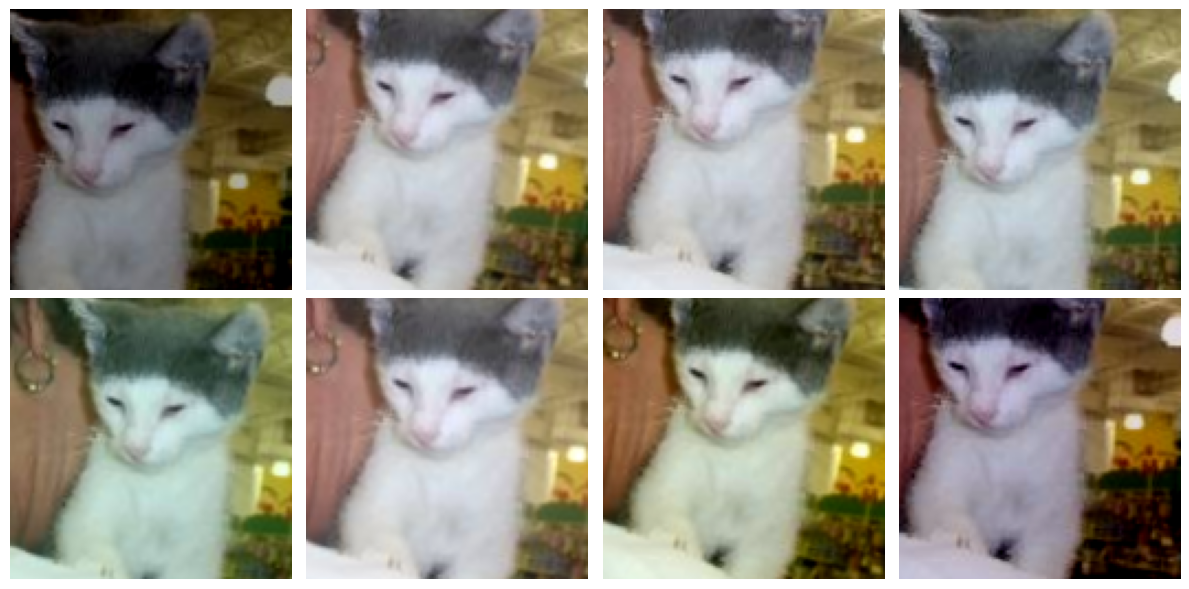

In [21]:
visualize_augmentations(train_loader.dataset)

In [22]:
history_training = {'accuracy':[],'loss':[]}
history_validation = {'accuracy':[],'loss':[]}
for epoch in range(1, params["epochs"] + 1):
    history_train = train(train_loader, model, criterion, optimizer, epoch, params)
    history_training['accuracy'].append((history_train[0]))
    history_training['loss'].append((history_train[1]))

    history_val = (validate(val_loader, model, criterion, epoch, params))
    history_validation['accuracy'].append((history_val[0]))
    history_validation['loss'].append((history_val[1]))

Epoch: 1. Train.      Loss: 0.697 | Accuracy: 0.602: 100%|██████████| 235/235 [17:45<00:00,  4.54s/it]
Epoch: 1. Validation. Loss: 0.751 | Accuracy: 0.648: 100%|██████████| 141/141 [03:33<00:00,  1.51s/it]


In [27]:
list(map(np.mean, history_training['accuracy']))

[0.6015735816448293]

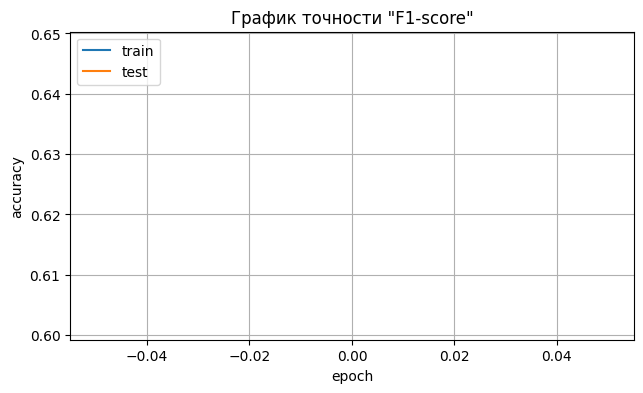

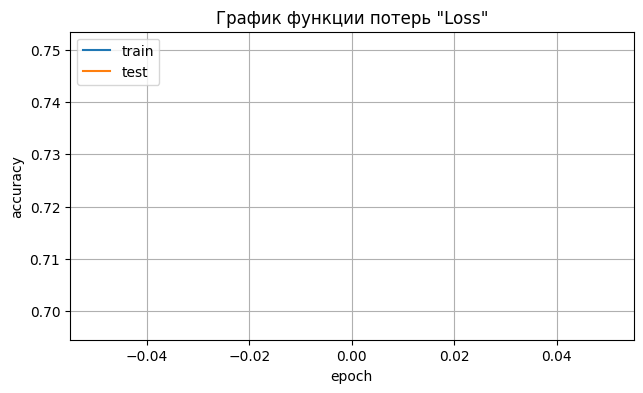

In [28]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)

ax.plot(list(map(np.mean, history_training['accuracy'])), label='train')
ax.plot(list(map(np.mean, history_validation['accuracy'])), label='val')
ax.set_title('График точности "F1-score"')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(list(map(np.mean, history_training['loss'])), label='train')
ax.plot(list(map(np.mean, history_validation['loss'])), label='val')
ax.set_title('График функции потерь "Loss"')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)
plt.show()

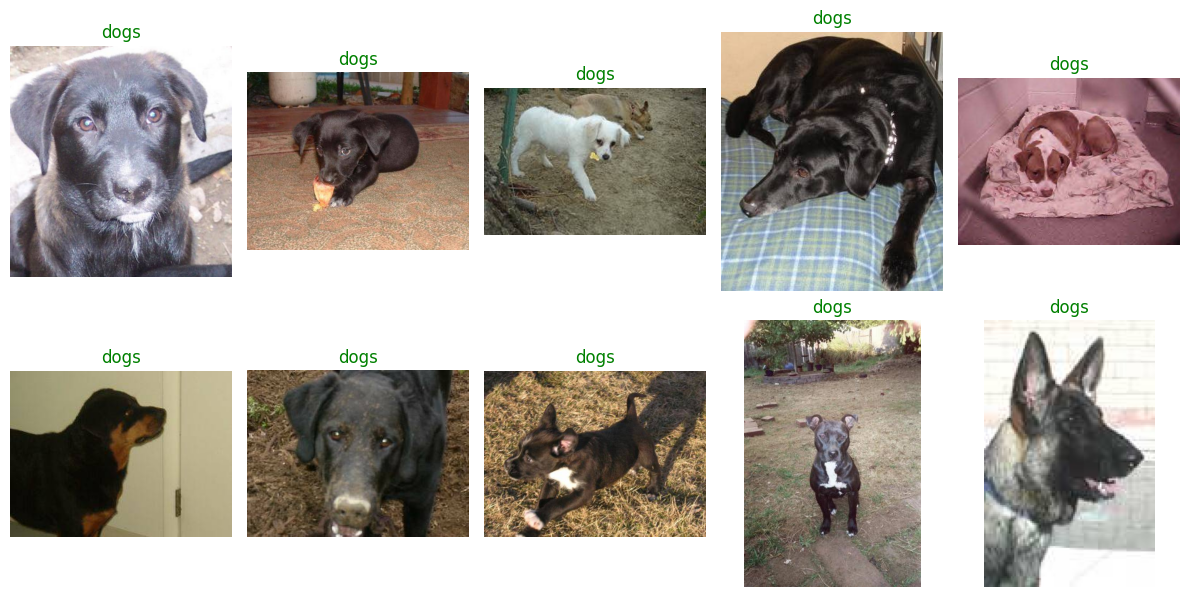

In [29]:
predicted_labels = predict(model, params, test_loader)

display_image_grid(test_images_filepaths)

[[4405 3103]
 [2036 5456]]
Precision of the Model :	0.6374576469213693
Recall of the Model    :	0.7282434596903363
F1 Score of the Model  :	0.679833032209831


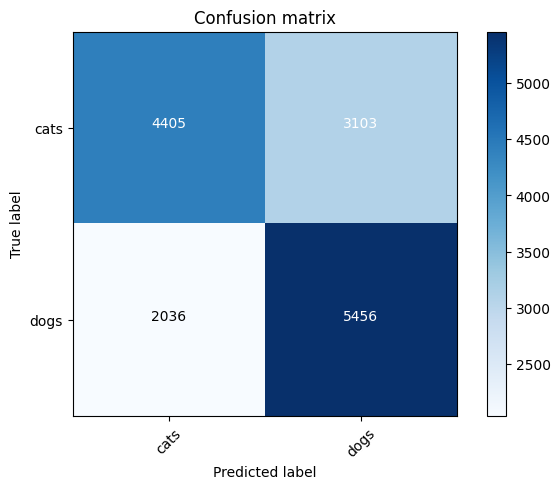

In [30]:
conf_matrix(model, params, train_loader)